# Comparação de Algorítimos aplicado ao Corpus McCabe

## Importar bibliotecas

In [21]:
import time
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pycm import ConfusionMatrix as cm

import os
import datetime as dt
from time import perf_counter

from igel import Igel

import logging

## Comfigurar os experimentos

As configurações dos experimentos estão nos seguintes arquivos *.YAML*

Todas as configurações aplicam 80% do conjunto de dados para treinamento e 20% para teste. Os dados são embaralhados.

In [22]:
# %load ../igel/classification_BernoulliNaiveBayes.yaml

In [23]:
# %load ../igel/classification_DecisionTree.yaml

In [24]:
# %load ../igel/classification_SVM.yaml

In [25]:
# %load ../igel/classification_RandomForest.yaml

## Preparar dados para previsão

### Carregar arquivo que será utilizado na previsão

In [26]:
#df = pd.read_csv('../_data/cm1.csv', sep=',', index_col=None)
df = pd.read_csv('../_data/kc2.csv', sep=',', index_col=None)
# Eliminar primeira linha, sempre inválida nestes conjuntos de dados
df.drop(df.index[0], inplace = True)

### Salvar dados originais

In [27]:
df_original = df.filter(['defects'], axis = 1)

df_original.to_csv('../_pre/_original.csv', index = False)

### Remover todas as colunas exceto os indicadores de McCabe

In [28]:
df.drop(df.columns.difference(['v(g)', 'ev(g)', 'iv(g)', 'loc']), 1, inplace=True)

### Pré-processar os dados para previsão

In [29]:
idxRowNan = pd.isnull(df).any(1).to_numpy().nonzero()
df.drop(df.index[idxRowNan], inplace = True)
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors = 'ignore')

def normalizar(data):
    
    m, n = data.shape # m = qtde de objetos e n = qtde de atributos por objeto
    
    # Incializa as variaves de saída
    data_norm = np.random.rand(m,n) #inicializa data_norm com valores aleatórios
    mu = 0 # inicializa a média
    sigma = 1 # inicializa o desvio padrão
     
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0, ddof=1)
    
    for i in range(m):
        data_norm[i,:] = (data[i,:]-mu) / sigma
        
    
    return data_norm, mu, sigma

df_temp = df.iloc[:,0:-1].to_numpy()
df_normal, mu, sigma = normalizar(df_temp)
df.iloc[:,0:-1] = df_normal

### Salvar o conjunto de dados para previsão¶

In [30]:
df.to_csv('../_pre/_copy.csv', index = False)

## Comparação de classificadores e regressores

### Executar classificador¶

In [31]:
def execute_experiment(paramFile, prefix):
    
    t_start = perf_counter()
    
    # TREINAMENTO
    params = {
        'cmd': 'fit',
        'data_path': '../_pre/jm1_mccabe_pre.csv',
        'yaml_path': '../igel/' + paramFile +'.yaml'
    }
    Igel(**params)

    # AVALIAÇÃO
    params = {
        'cmd': 'evaluate',
        'data_path': '../_pre/jm1_mccabe_pre.csv',
        'yaml_path': '../igel/' + paramFile +'.yaml'
    }
    Igel(**params)

    # PREVISÃO
    params = {
        'cmd': 'predict',
        'data_path': '../_pre/_copy.csv',
        'yaml_path': '../igel/' + paramFile +'.yaml'
    }
    Igel(**params)
    
    t_stop = perf_counter()
    
    elapsed_time = t_stop - t_start
    
    # COMPARAÇÃO DOS RESULTADOS
    df_original = pd.read_csv('../_pre/_original.csv', sep=',', index_col=None)
    df_predictions = pd.read_csv('./model_results/predictions.csv', sep=',', index_col=None)
    cols = df_predictions.columns
    df_predictions[cols] = df_predictions[cols].apply(pd.to_numeric, errors = 'coerce', downcast = 'unsigned')
    
    # Matriz de confusão - Defeitos
    defects_cm = cm(actual_vector = df_original['defects'].to_numpy(), predict_vector = df_predictions['defects_binned'].to_numpy())
    
    # MOVER EXPERIMENTO PARA UMA PASTA SEPARADA
    current_date = dt.datetime.today().strftime ('%Y-%m-%d-%H-%M-%S')
    os.rename(r'./model_results', r'./.result_' + prefix + '_' + str(current_date))
    
    return {
        'elapsed_time': elapsed_time,
        'defects_cm': defects_cm,
    }

logging.getLogger('igel').setLevel(logging.ERROR)

### Executar experimentos

#### Naïve Bayes

In [32]:
naive_bayes = execute_experiment('classification_BernoulliNaiveBayes', 'BNB')

#### Decision Tree

In [33]:
decision_tree = execute_experiment('classification_DecisionTree', 'DT')

#### Support Vector Machine¶

In [34]:
support_vector_machine = execute_experiment('classification_SVM', 'SVM')

#### Random Forest

In [35]:
random_forest = execute_experiment('classification_RandomForest', 'RF')

## Comparação

### Função de comparação

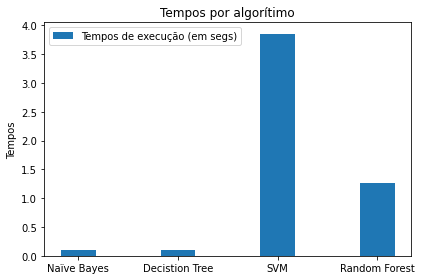

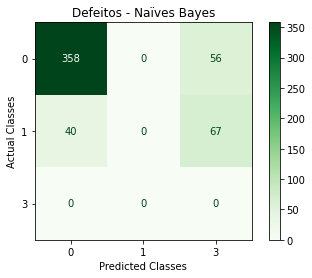

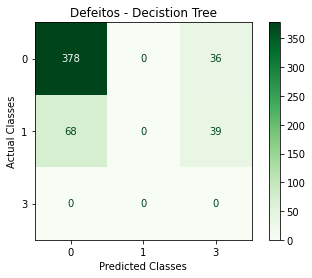

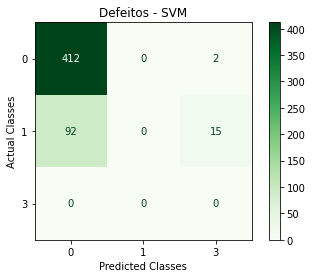

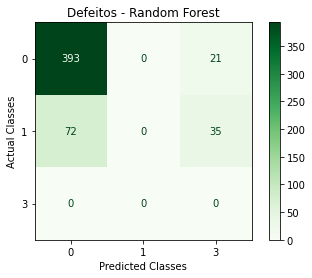

In [36]:
labels = [ 'Naïve Bayes', 'Decistion Tree', 'SVM', 'Random Forest' ]
elapsed_times = [ naive_bayes['elapsed_time'], decision_tree['elapsed_time'], support_vector_machine['elapsed_time'], random_forest['elapsed_time'] ]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects_elapsed_times = ax.bar(x, elapsed_times, width, label='Tempos de execução (em segs)')
ax.set_ylabel('Tempos')
ax.set_title('Tempos por algorítimo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

naive_bayes['defects_cm'].plot(cmap = plt.cm.Greens, number_label = True, title = 'Defeitos - Naïves Bayes', plot_lib = 'matplotlib')
decision_tree['defects_cm'].plot(cmap = plt.cm.Greens, number_label = True, title = 'Defeitos - Decistion Tree', plot_lib = 'matplotlib')
support_vector_machine['defects_cm'].plot(cmap = plt.cm.Greens, number_label = True, title = 'Defeitos - SVM', plot_lib = 'matplotlib')
random_forest['defects_cm'].plot(cmap = plt.cm.Greens, number_label = True, title = 'Defeitos - Random Forest', plot_lib = 'matplotlib')
plt.show()

> This is the end